---
$$\boxed{\text{\Large{\color{pink}Agentic AI Workshop Day-1}}}$$

$$\text{\textbf{\color{yellow}Theme}: \underline{retrieval before generation, representations before models}}$$
$$\text{\textbf{\color{cyan}Goal}: \underline{to understand that large language models (LLMs) are useless without high quality retrieval}}$$

Today we will explore **how information retrieval systems work from first principles**, using Kannada crime descriptions scraped from the Udupi Police's website. No LLMs today; retrieval comes first.

**Topics**:

1. Kannada text preprocessing
   
2. Classical information retrieval (Inverted Index → Boolean → Phrase)
   
3. Vector Space Model (TF-IDF + Cosine Similarity)
   
4. Pretrained embeddings (semantic retrieval)
   
5. Custom embeddings (small PyTorch model)
   
6. Synthesis & comparison


---


---

Import libraries

---

In [ ]:
import pandas as pd
import numpy as np
import math
import os
import sys
import re
import random
import unicodedata
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('dark_background')
%matplotlib inline

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch: 2.9.0+cpu
CUDA available: False


---

Mount Google Drive if running in Colab

---

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    DIR = '/content/drive/MyDrive/Colab Notebooks/MAHE/MSIS Coursework/OddSem2025MAHE/Share/Agentic Workshop/For Students'
    DATA_DIR = DIR + '/Data/'
    os.chdir(DIR)
else:
    DATA_DIR = '../Data/'

Mounted at /content/drive


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/MAHE/MSIS Coursework/OddSem2025MAHE/Share/Agentic Workshop/For Students'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---

Load Udupi crime data

Expected CSV columns:

- Crime Type
- Location
- Day of Week (label encoded: 0–6)
- Time of Day (0–3)
- Day
- Month
- Year
- Crime Description (Kannada text)

---

In [ ]:
## Load Udupi crime data
#file =DATA_DIR + 'UdupiCrimeData.csv'
file = '/content/drive/MyDrive/Colab Notebooks/agentic_ai_workshop/Data/UdupiCrimeData.csv'
df= pd.read_csv(file, header = 0).dropna()

print('Udupi crime dataset')
print('-----------')
print('Number of records = %d'%(df.shape[0]))
print('Number of features = %d\n'%(df.shape[1]))
df.head(5)

Udupi crime dataset
-----------
Number of records = 13457
Number of features = 8



,Crime Type,Location,Day of Week,Time of Day,Day,Month,Year,Crime Description
0,ಮಟ್ಕಾ ಜುಗಾರಿ ಪ್ರಕರಣ,ಗಂಗೊಳ್ಳಿ,6.0,2.0,29.0,2.0,2020.0,ಭೀಮಶಂಕರ್ ಎಸ್ ಎಸ್ ಪಿ ಎಸ್ ಐ ಗಂಗೊಳ್ಳಿ ಪೊಲಿಸ್ ಠಾಣೆ...
1,ಅಸ್ವಾಭಾವಿಕ ಮರಣ ಪ್ರಕರಣ,ಕೊಲ್ಲೂರು,6.0,0.0,29.0,2.0,2020.0,ಪಿರ್ಯಾದಿದಾರರಾಧ ಶ್ರೀಮತಿ ಸಂಧ್ಯಾ ( 59 ವರ್ಷ) ಗಂಡ: ...
2,ಅಸ್ವಾಭಾವಿಕ ಮರಣ ಪ್ರಕರಣ,ಉಡುಪಿ,6.0,1.0,29.0,2.0,2020.0,"ಪಿರ್ಯಾದಿದಾರರಾದ ಕೆ ರಾಘವೇಂದ್ರ ಸರಳಾಯ(67), ತಂದೆ: ದ..."
3,ಮನುಷ್ಯ ಕಾಣೆ ಪ್ರಕರಣ,ಶಿರ್ವಾ,4.0,0.0,27.0,2.0,2020.0,"ಪಿರ್ಯಾದಿದಾರರಾದ ಕಿಶೋರ್‌ಆಚಾರ್ಯ (31), ತಂದೆ:ಉಪೇಂದ್..."
8,ಅಪಘಾತ ಪ್ರಕರಣ,ಮಲ್ಪೆ,5.0,1.0,21.0,2.0,2020.0,ದಿನಾಂಕ 21/02/2020 ರಂದು 14:00 ಗಂಟೆಗೆ ಪಿರ್ಯಾದಿದಾ...


---

**Kannada Text Preprocessing**:

- Kannada uses complex unicode characters

- Whitespace tokenization is imperfect: tokenization ≠ English tokenization

- Normalization matters

**Hands-on**:

1. Build a minimal tokenizer

2. Inspect word frequency


---

In [ ]:
## Function to remove every character that is NOT a Kannada character OR whitespace leaving only Kannada letters,
## vowels, and matras, and spaces and line breaks.
def normalize_text(text):
  text = str(text)

  # Normalize unicode representation
  text = unicodedata.normalize("NFKC", text)

  # Unicode range for Kannada: U+0C80 – U+0CFF, Devanagari: U+0900 – U+097F, Tamil: U+0B80 – U+0BFF
  text = re.sub(r"[^\u0C80-\u0Cff\s]", " ", text)

  # Normalize multiple whitespaces
  text = re.sub(r"\s+", " ", text)
  return text.strip()

## Simple whitespace tokenizer for Kannada text

def tokenize(text):
  return normalize_text(text).split()

df["tokens"] = df["Crime Description"].apply(tokenize)
df["tokens"].head()

# Get top 20 common tokens
vocab_counter = Counter()

for tokens in df["tokens"]:
    vocab_counter.update(tokens)

vocab_counter.most_common(20)

[('ಬಗ್ಗೆ', 18347),
 ('ದಿನಾಂಕ', 16582),
 ('ರಂದು', 15890),
 ('ಪೊಲೀಸ್', 15847),
 ('ಕಲಂ', 13857),
 ('ಈ', 13778),
 ('ಗಂಟೆಗೆ', 13616),
 ('ಪ್ರಕರಣ', 13557),
 ('ಕ್ರಮಾಂಕ', 13318),
 ('ವಾಸ', 12746),
 ('ದಾಖಲಾಗಿರುತ್ತದೆ', 12463),
 ('ತಂದೆ', 12292),
 ('ಹಾಗೂ', 12278),
 ('ಉಡುಪಿ', 11620),
 ('ತಾಲೂಕು', 10895),
 ('ಅಪರಾಧ', 10882),
 ('ಠಾಣೆ', 10631),
 ('ಗ್ರಾಮ', 10389),
 ('ಕುಂದಾಪುರ', 10268),
 ('ಪಿರ್ಯಾದಿದಾರರಾದ', 8881)]

In [ ]:
df['tokens'].head()

,tokens
0,"[ಭೀಮಶಂಕರ್, ಎಸ್, ಎಸ್, ಪಿ, ಎಸ್, ಐ, ಗಂಗೊಳ್ಳಿ, ಪೊಲ..."
1,"[ಪಿರ್ಯಾದಿದಾರರಾಧ, ಶ್ರೀಮತಿ, ಸಂಧ್ಯಾ, ವರ್ಷ, ಗಂಡ, ದ..."
2,"[ಪಿರ್ಯಾದಿದಾರರಾದ, ಕೆ, ರಾಘವೇಂದ್ರ, ಸರಳಾಯ, ತಂದೆ, ದ..."
3,"[ಪಿರ್ಯಾದಿದಾರರಾದ, ಕಿಶೋರ್, ಆಚಾರ್ಯ, ತಂದೆ, ಉಪೇಂದ್ರ..."
8,"[ದಿನಾಂಕ, ರಂದು, ಗಂಟೆಗೆ, ಪಿರ್ಯಾದಿದಾರರಾದ, ವಿಶ್ವನಾ..."


---

**Information Retrieval Using Inverted Positional Index**:

- We want a data structure that answers queries like:
  - “which documents contain the word ಕಳ್ಳತನ?”
  - “Where exactly does that word occur in each document?”
  - “Do the words ಮನೆಯೊಳಗೆ ಕಳ್ಳತನ appear consecutively?”

- We build a dictionary: word → { doc_id → [positions] }  (normal index: document → words, inverted index: word → documents)

- This enables: boolean retrieval, phrase queries, and explainable search

- backbone of classical search; everything modern retrieval builds on this idea
  
**Hands on:**

1. Build an inverted positional index for 1,000 crime records and query

---

In [ ]:
inverted_index = defaultdict(lambda: defaultdict(list))

for doc_id, tokens in enumerate(df["tokens"]):
    for pos, word in enumerate(tokens):
        inverted_index[word][doc_id].append(pos)

len(inverted_index)

61671

In [ ]:
list(inverted_index.keys())[10]

'ಗ್ರಾಮದ'

In [ ]:
## Query a term
term = list(inverted_index.keys())[10]
print(term)
inverted_index[term]

ಗ್ರಾಮದ


defaultdict(list,
            {0: [13, 26],
             1: [53],
             6: [22],
             7: [3],
             9: [13],
             10: [43],
             11: [53],
             12: [3],
             14: [16, 40],
             15: [26],
             17: [67],
             20: [7],
             23: [40],
             24: [8],
             27: [41],
             29: [14],
             30: [11],
             33: [16],
             37: [14],
             38: [17],
             39: [33],
             40: [39],
             41: [42],
             44: [6],
             45: [19],
             48: [26],
             49: [33],
             50: [4],
             52: [32],
             56: [10],
             57: [17],
             58: [42],
             60: [36],
             62: [7],
             64: [7],
             65: [14],
             66: [19],
             69: [15],
             70: [39],
             71: [11],
             73: [41],
             74: [6],
             77: [7],


---

**Boolean Retrieval**:

- Query examples using Boolean operators AND, OR, NOT such as "theft AND evening", "assault AND NOT night"

- Exact, fast, and legally explainable — but brittle


**Hands on:**

1. Query "ಕಳ್ಳತನ" and "ಮನೆ"

---

In [ ]:
## Boolean operators
def AND(set1, set2):
    return set1.intersection(set2)

def OR(set1, set2):
    return set1.union(set2)

def NOT(set1, universe):
    return universe - set1


In [ ]:
universe = set(range(len(df)))

#term1_docs = set(inverted_index["ಕಳ್ಳತನ"].keys())
term1_docs = set(inverted_index["ಪೊಲೀಸ್"].keys())
term2_docs = set(inverted_index["ಠಾಣೆ"].keys())

AND(term1_docs, term2_docs)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 78,
 79,
 80,
 81,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 127,
 128,
 131,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200

---

**Phrase Query Retrieval**:

- Works by finding documents where words appear consecutively and in an exact order: example "ಮನೆಯೊಳಗೆ ಕಳ್ಳತನ ನಡೆದಿದೆ"
  
- Limitations: synonyms, paraphrases, spelling variants

- much stricter than Boolean AND: word order matters

**Hands on:**

1. Query "ಮನೆಯೊಳಗೆ ಕಳ್ಳತನ"

---

In [ ]:
## Phrase query function
def phrase_query(terms):
  # Look up the first word of the phrase and get all documents
  # that contain it
  candidate_docs = set(inverted_index[terms[0]].keys())

  # For every remaining word: intersect document sets which
  # ensures every candidate document contains all words. This
  # is Boolean retrieval as a pre-filter.
  for term in terms[1:]:
    candidate_docs &= set(inverted_index[term].keys())

  results = []
  # Iterate over all candidate documents
  for doc in candidate_docs:
    # Positions of the first term
    positions = inverted_index[terms[0]][doc]
    # Try matching phrase starting at each position
    for pos in positions:
      # If term-0 at position pos, term-1 at pos+1 etc.,
      # we have the correct order with no gaps. Append doc.
      if all((pos + i) in inverted_index[terms[i]][doc] for i in range(len(terms))):
        results.append(doc)
        break
  return results

In [ ]:
## Phrase query test
#terms = ["ಮನೆಯೊಳಗೆ", "ಕಳ್ಳತನ"]
#terms = ["ರಂದು", "ಮಹಾದೇವ", "ಬೋಸಲೆ"]
terms = ['ಪೊಲೀಸ್', 'ಠಾಣೆ']
phrase_query(terms)

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 78,
 79,
 80,
 81,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 127,
 128,
 131,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 

---

**TF-IDF Model**:

- Vector space model--bridge to word embeddings
  
- The first ranking-based retrieval model, acting as a conceptual bridge between symbolic information retrieval and beural embeddings used later in RAG systems

- Answers the question "which document is more relevant"

- Assigns a **real-valued importance score** to every word in every document:$$\text{TF‑IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)$$ where
    - t = term (word)
    - d = document (crime description)

- TF answers the question "how important is this word *inside this document*?" thus capturing local importance of the word:$$\text{TF}(t, d) = \frac{\text{count of } t \text{ in } d}{\text{total words in } d}$$

- IDF answers the question "how rare is this word across *all* documents?" thus capturing the gloval importance of the word:$$\text{IDF}(t) = \log\left(\frac{N}{1 + \text{DF}(t)}\right)$$where:
  - N = total number of documents
  - DF(t) = number of documents containing term t

- TF‑IDF = Local × Global importance rewarding words that
  - occur frequently in a document, **and**
  - are rare across the dataset


**Hands on:**

1. Compute term frequency (TF) and inverse document frequency (IDF)

2. Build document vectors

3. Rank crime data for query


---

In [ ]:
## Calculate TF-IDF
texts = df['Crime Description'].apply(normalize_text).to_list()

tfidf = TfidfVectorizer(tokenizer = tokenize)
X = tfidf.fit_transform(texts)

c:\Users\Admin\miniconda3\envs\agentic\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
print(len(vocab_counter))
print(df.shape[0])
print(X.shape)
print(X[:, 5])
print(tokens[5])

61671
13457
(13457, 61671)
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 13 stored elements and shape (13457, 1)>
  Coords	Values
  (29, 0)	0.25974651099930185
  (2312, 0)	0.15678548746304757
  (3772, 0)	0.23370531787312185
  (5653, 0)	0.07716960041224155
  (6072, 0)	0.09197638746680273
  (9040, 0)	0.1943430842396178
  (9671, 0)	0.15065785497193038
  (10547, 0)	0.28229999100245023
  (12503, 0)	0.16062288163088478
  (12854, 0)	0.4159073220206462
  (12860, 0)	0.1605759733853852
  (12910, 0)	0.11566385826172401
  (13038, 0)	0.11817559976137437
ಶೆಟ್ಟಿ


In [ ]:
# query = "ಮನೆಯೊಳಗೆ ಕಳ್ಳತನ"
# q_vec = tfidf.transform([query])
# print(q_vec)

In [ ]:
myarray = np.array([-1, 2, -4, 5, 3, 10, 12, 4, 7])
-np.sort(-myarray)
myarray.argsort()[-5:][::-1]

array([6, 5, 8, 3, 7], dtype=int64)

In [ ]:
## Function for ranking query
def rank_tfidf(query, top_k = 5):
  q_vec = tfidf.transform([query])
  similarities = cosine_similarity(q_vec, X)[0]
  top_doc_ids = similarities.argsort()[-top_k:][::-1]
  return top_doc_ids, similarities[top_doc_ids]

#query="ಮನೆಯೊಳಗೆ ಕಳ್ಳತನ"
query="ಮನೆಯೊಳಗೆ ಕಳ್ಳತನ"
rank_tfidf(query)

(array([13393, 11751, 10228,  2848, 12995], dtype=int64),
 array([0.27435807, 0.15683271, 0.15316879, 0.14908113, 0.14824458]))

In [ ]:
df.iloc[13393]['Crime Description']


'ದಿನಾಂಕ. 11/08/2015 ರಂದು ಮದ್ಯಾಹ್ನ 2:30 ಗಂಟೆಯ ಸಮಯಕ್ಕೆ ಪಿರ್ಯಾದಿದಾರರಾದ ರಹೀಂ ಕುಂಜೂರು (42), ವಾಸ:- ದುರ್ಗಾ ನಗರ, ಕುಂಜೂರು, ಎಲ್ಲೂರು ಗ್ರಾಮ, ಉಡುಪಿ ತಾಲೂಕು ಮತ್ತು ಜಿಲ್ಲೆ ಇವರ ಮನೆಯೊಳಗೆ ಆರೋಪಿತನಾದ ರಂಜಿತ್ ಶೆಟ್ಟಿ ಎಂಬುವವನು ಕೈಯಲ್ಲಿ ಮರದ ಬ್ಯಾಟ್\u200cನ್ನು ಹಿಡಿದುಕೊಂಡು ಮನೆಯ ಗೇಟ್\u200cನ ಕಂಬದ ಲೈಟ್\u200cನ್ನು ಪುಡಿಮಾಡಿ, ನಂತರ ಏಕಾಏಕಿ ಮನೆಯೊಳಗೆ ನುಗ್ಗಿ ಅವಾಚ್ಯ ಶಬ್ದಗಳಿಂದ ಬೈದು ಕಿಟಕಿ ಬಾಗಿಲಿನ ಗಾಜುಗಳನ್ನು ಪುಡಿ ಮಾಡಿ ಜೀವ ಬೆದರಿಕೆ ಹಾಕಿ, ಬಳಿಕ ಈತನು ಪಕ್ಕದಲ್ಲಿರುವ ಮುಮ್ತಾಜ್\u200cರವರ ಮನೆಯೊಳಗೆ ನುಗ್ಗಿ ಟಿವಿ ಶೋಕೇಸ್\u200c,ಅಕ್ವೇರಿಯಮ್\u200c, ಸ್ವಿಚ್\u200cಬೋರ್ಡ್\u200c, ಕಪಾಟ್\u200cನ ಕನ್ನಡಿ, ಬೊಬೈಲ್\u200c, ಟಾರ್ಚ್\u200cನ್ನು ಹುಡಿ ಮಾಡಿ, ಬಳಿಕ ಪಕ್ಕದಲ್ಲಿರುವ ಕಿಶೋರ್\u200c ಎಂಬವರ ಮನೆಗೆ ನುಗ್ಗಿ ಅವರ ಮನೆಯೊಳಗೆ ಇದ್ದ ಪೈಬರ್\u200c ಕುರ್ಚಿಯನ್ನು ಪುಡಿ ಮಾಡಿ ನಷ್ಟವನ್ನುಂಟು ಮಾಡಿರುತ್ತಾನೆ. ಈ ಬಗ್ಗೆ ಪಡುಬಿದ್ರಿ ಪೋಲಿಸ್ ಠಾಣೆ ಅಪರಾಧ ಕ್ರಮಾಂಕ 106/2015 ಕಲಂ; 447, 448, 454, 427, 504, 506 ಐಪಿಸಿಯಂತೆ ಪ್ರಕರಣ ದಾಖಲಾಗಿರುತ್ತದೆ.'

---

**Pretrained Embeddings**:

- sentence-transformers/paraphrase-multilingual-MiniLM
  
- IndicSBERT variants

- Black box vs explainability

- Approximate similarity

- Memory cost

**Hands on:**

1. Encode crime data
   
2. Encode queries
   
3. Compare vs TF-IDF results
   
4. Compare top-5 results from TF-IDF vs embeddings
   
5. Which crime data appear only in embedding-based retrieval?


---

In [ ]:
import transformers
import sentence_transformers

print("torch:",torch.__version__)
print("transformers:", transformers.__version__)
print("sentence-transformers", sentence_transformers.__version__)

torch: 2.9.1+cpu
transformers: 4.41.0
sentence-transformers 5.2.0


In [ ]:
##Load the pre-trained embedding model
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer(
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)

c:\Users\Admin\miniconda3\envs\agentic\lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
texts = df['Crime Description'].apply(normalize_text).to_list()
print(texts[0])
print(len(embedder.encode(texts[0])))
tfidf = TfidfVectorizer(tokenizer = tokenize)
X = tfidf.fit_transform(texts)
print(np.sum(X[0].todense()!=0))

ಭೀಮಶಂಕರ್ ಎಸ್ ಎಸ್ ಪಿ ಎಸ್ ಐ ಗಂಗೊಳ್ಳಿ ಪೊಲಿಸ್ ಠಾಣೆ ರವರು ದಿನಾಂಕ ರಂದು ಗಂಗೊಳ್ಳಿ ಗ್ರಾಮದ ಖಾರ್ವಿಕೇರಿ ರಸ್ತೆಯ ಸಾರ್ವಜನಿಕ ಸ್ಥಳದಲ್ಲಿ ಪಂಜು ಪೂಜಾರಿ ಎಂಬುವವರು ಮಟ್ಕಾ ಜುಗಾರಿ ನಡೆಸುತ್ತಿದ್ದ ಬಗ್ಗೆ ಸದ್ರಿ ಗ್ರಾಮದ ಬೀಟ್ ಸಿಬ್ಬಂದಿ ನಾಗರಾಜ ಕುಲಾಲ್ ರವರು ನೀಡಿದ ಖಚಿತ ಮಾಹಿತಿಯಂತೆ ಠಾಣಾ ಪಿ ಎಸ್ ಐ ರವರು ಸಿಬ್ಬಂದಿಗಳೊಂದಿಗೆ ಸದ್ರಿ ಸ್ಥಳಕ್ಕೆ ಹೋಗಿ ಗಂಟೆಗೆ ಧಾಳಿ ನಡೆಸಿ ಮಟ್ಕ ಚೀಟಿ ಬರೆಯುತ್ತಿದ್ದ ಆಪಾದಿತ ಪಂಜು ಪೂಜಾರಿ ತಂದೆ ರಾಮ ಪೂಜಾರಿ ಗಂಗೊಳ್ಳಿ ಇವರನ್ನು ವಶಕ್ಕೆ ಪಡೆದು ವಿಚಾರಿಸಿದಲ್ಲಿ ತಾನು ಸ್ವಂತ ಲಾಭಕ್ಕೋಸ್ಕರ ಸಾರ್ವಜನಿಕರಿಂದ ಹಣ ಸಂಗ್ರಹಿಸುತ್ತಿರುವುದಾಗಿ ತಿಳಿಸಿದ್ದು ಮಟ್ಕಾ ಜುಗಾರಿಗೆ ಬಳಸಿದ ಮಟ್ಕ ಚೀಟಿ ಬಾಲ್ ಪೆನ್ನು ಹಾಗೂ ರೂಪಾಯಿ ನಗದು ಹಣವನ್ನು ಸ್ವಾಧೀನ ಪಡಿಸಿಕೊಂಡಿರುವುದಾಗಿದೆ ಈ ಬಗ್ಗೆ ಗಂಗೊಳ್ಳಿ ಪೊಲೀಸ್ ಠಾಣಾ ಅಪರಾಧ ಕ್ರಮಾಂಕ ಕಲಂ ಕರ್ನಾಟಕ ಪೊಲೀಸ್ ಕಾಯ್ದೆಯಂತೆ ಪ್ರಕರಣ ದಾಖಲಾಗಿರುತ್ತದೆ
384


c:\Users\Admin\miniconda3\envs\agentic\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


73


In [ ]:
## Embed the crime report
texts = df['Crime Description'].apply(normalize_text).to_list()

X_embeddings = embedder.encode(texts, show_progress_bar = True)

Batches:   0%|          | 0/421 [00:00<?, ?it/s]

MiniLM is a compressed transformer encoder

In [ ]:
## Function for ranking query
def semantic_search(query, top_k = 5):
  q_vec = embedder.encode([query])
  similarities = cosine_similarity(q_vec, X_embeddings)[0]
  top_doc_ids = similarities.argsort()[-top_k:][::-1]
  return top_doc_ids, similarities[top_doc_ids]

#query="ಮನೆಯೊಳಗೆ ಕಳ್ಳತನ"
query="ಮನೆಯೊಳಗೆ ಕಳ್ಳತನ"
semantic_search(query)

(array([ 8440, 13300,  6161,  2947, 12377], dtype=int64),
 array([0.2689608 , 0.2530484 , 0.24703234, 0.24104765, 0.23947811],
       dtype=float32))

In [ ]:
df['Crime Description'].iloc[8440]

'ಬೆಳ್ಳೆ ಗ್ರಾಮ ಪಂಚಾಯತ್\u200c ವ್ಯಾಪ್ತಿಯ ಕುಕ್ಕುದಕಟ್ಟೆ ಎಂಬಲ್ಲಿ 2016 ಜೂನ್\u200c ತಿಂಗಳಲ್ಲಿ ಅಳವಡಿಸಿದ್ದ ಸೋಲಾರ್ ದೀಪದ ಪ್ಯಾನಲ್\u200c ಮತ್ತು ಬ್ಯಾಟರಿಯನ್ನು ದಿನಾಂಕ 25/04/2017 ರಂದು 23:00 ಗಂಟೆಯಿಂದ ದಿನಾಂಕ 28/04/2017 ರಂದು 18:30 ಗಂಟೆ ನಡುವಿನ ಅವಧಿಯಲ್ಲಿ ಯಾರೋ ಕಳ್ಳರು ಕಳವು ಮಾಡಿಕೊಂಡು ಹೋಗಿರುತ್ತಾರೆ. ಕಳವಾದ ಬ್ಯಾಟರಿ ಮತ್ತು ಪ್ಯಾನೆಲ್\u200cನ ಮೌಲ್ಯ ರೂಪಾಯಿ 7,000/- ಆಗಿರುತ್ತದೆ. ಈ ಬಗ್ಗೆ ಶಿರ್ವಾ ಪೊಲೀಸ್ ಠಾಣೆ ಅಪರಾಧ ಕ್ರಮಾಂಕ 51/2017, ಕಲಂ: 379 ಐಪಿಸಿಯಂತೆ ಪ್ರಕರಣ ದಾಖಲಾಗಿರುತ್ತದೆ.'

---

**Custom Embeddings**:

- aim not to beat SBERT — learn why it works

- representation learning mindset
  

**Hands on:**

1. Simple PyTorch model (token embedding, mean pooling, contrastive loss / cosine loss, embedding dim: 32 or 64 or 128?)

2. Compare retrieval quality of TF-IDF, pretrained embeddings, and custom embeddings


---

In [ ]:
#vocab_counter

In [ ]:
word2idx={w:i for i,w in enumerate(vocab_counter.keys())}
idx2word={i:w for w,i in word2idx.items()}

def encode_doc(tokens):
    return[word2idx[t] for t in tokens if t in word2idx]

In [ ]:
texts = df['Crime Description'].apply(normalize_text).tolist()
print(texts[0])
encode_doc(texts[0])

ಭೀಮಶಂಕರ್ ಎಸ್ ಎಸ್ ಪಿ ಎಸ್ ಐ ಗಂಗೊಳ್ಳಿ ಪೊಲಿಸ್ ಠಾಣೆ ರವರು ದಿನಾಂಕ ರಂದು ಗಂಗೊಳ್ಳಿ ಗ್ರಾಮದ ಖಾರ್ವಿಕೇರಿ ರಸ್ತೆಯ ಸಾರ್ವಜನಿಕ ಸ್ಥಳದಲ್ಲಿ ಪಂಜು ಪೂಜಾರಿ ಎಂಬುವವರು ಮಟ್ಕಾ ಜುಗಾರಿ ನಡೆಸುತ್ತಿದ್ದ ಬಗ್ಗೆ ಸದ್ರಿ ಗ್ರಾಮದ ಬೀಟ್ ಸಿಬ್ಬಂದಿ ನಾಗರಾಜ ಕುಲಾಲ್ ರವರು ನೀಡಿದ ಖಚಿತ ಮಾಹಿತಿಯಂತೆ ಠಾಣಾ ಪಿ ಎಸ್ ಐ ರವರು ಸಿಬ್ಬಂದಿಗಳೊಂದಿಗೆ ಸದ್ರಿ ಸ್ಥಳಕ್ಕೆ ಹೋಗಿ ಗಂಟೆಗೆ ಧಾಳಿ ನಡೆಸಿ ಮಟ್ಕ ಚೀಟಿ ಬರೆಯುತ್ತಿದ್ದ ಆಪಾದಿತ ಪಂಜು ಪೂಜಾರಿ ತಂದೆ ರಾಮ ಪೂಜಾರಿ ಗಂಗೊಳ್ಳಿ ಇವರನ್ನು ವಶಕ್ಕೆ ಪಡೆದು ವಿಚಾರಿಸಿದಲ್ಲಿ ತಾನು ಸ್ವಂತ ಲಾಭಕ್ಕೋಸ್ಕರ ಸಾರ್ವಜನಿಕರಿಂದ ಹಣ ಸಂಗ್ರಹಿಸುತ್ತಿರುವುದಾಗಿ ತಿಳಿಸಿದ್ದು ಮಟ್ಕಾ ಜುಗಾರಿಗೆ ಬಳಸಿದ ಮಟ್ಕ ಚೀಟಿ ಬಾಲ್ ಪೆನ್ನು ಹಾಗೂ ರೂಪಾಯಿ ನಗದು ಹಣವನ್ನು ಸ್ವಾಧೀನ ಪಡಿಸಿಕೊಂಡಿರುವುದಾಗಿದೆ ಈ ಬಗ್ಗೆ ಗಂಗೊಳ್ಳಿ ಪೊಲೀಸ್ ಠಾಣಾ ಅಪರಾಧ ಕ್ರಮಾಂಕ ಕಲಂ ಕರ್ನಾಟಕ ಪೊಲೀಸ್ ಕಾಯ್ದೆಯಂತೆ ಪ್ರಕರಣ ದಾಖಲಾಗಿರುತ್ತದೆ


[5379,
 2442,
 417,
 136,
 6663,
 136,
 6663,
 13734,
 136,
 6663,
 3,
 36918,
 36918,
 22596,
 22596,
 13734,
 6663,
 25866,
 417,
 41400,
 417,
 1233,
 295,
 2442,
 417,
 1233,
 36918,
 36918,
 22596,
 22596,
 36918,
 417,
 5379,
 1233,
 417,
 41400,
 2442,
 417,
 417,
 6663,
 8012,
 3656,
 6663,
 417,
 41400,
 33457,
 295,
 2442,
 6663,
 22596,
 1233,
 13734,
 33457,
 13734,
 33457,
 417,
 136,
 36283,
 41400,
 41400,
 417,
 5379,
 2442,
 33457,
 36918,
 417,
 295,
 28196,
 6663,
 8012,
 8012,
 1233,
 1233,
 36283,
 36918,
 36918,
 6663,
 1233,
 417,
 36918,
 417,
 5379,
 1233,
 36283,
 6663,
 36283,
 36283,
 1233,
 295,
 36918,
 417,
 33457,
 2442,
 417,
 41400,
 417,
 295,
 28196,
 1233,
 43052,
 8012,
 5379,
 16602,
 8012,
 3656,
 8012,
 25866,
 13734,
 136,
 6663,
 3,
 417,
 41400,
 417,
 6663,
 36283,
 36283,
 1233,
 36918,
 22596,
 1233,
 36918,
 6663,
 1233,
 417,
 6663,
 22596,
 2442,
 2442,
 16602,
 36918,
 36918,
 36918,
 22596,
 295,
 28196,
 6663,
 5379,
 2442,
 43052,
 

**Comparing Information Retrieval Techniques**:

| Method         | Explainable | Semantic | Memory | Speed  |
| -------------- | ----------- | -------- | ------ | ------ |
| Boolean        | ?           | ?        | ?    | ?   |
| TF-IDF         | ?          | ?       | ? | ?   |
| Pretrained Emb | ?           | ?        | ?   | ? |
| Custom Emb     | ?          | ?       | ?    | ?   |

**How Day-1 Concepts Lead to Day-2 Use?**

| Day-1 Concept     | Day-2 Use                      |
| ----------------- | ------------------------------ |
| Inverted index    | Keyword filtering before RAG   |
| TF-IDF            | Sparse retriever in hybrid RAG |
| Embeddings        | Vector store                   |
| Custom embeddings | Memory-efficient RAG           |
| Dimensionality    | QLoRA intuition                |


In [ ]:
## simple embedder module
class SimpleEmbedder(nn.Module):
    def __init__(self, vocab_size, dim = 8):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, dim)

    def forward(self, x):
        return self.embed(x).mean(dim = 0)

In [ ]:
df['tokens']

,tokens
0,"[ಭೀಮಶಂಕರ್, ಎಸ್, ಎಸ್, ಪಿ, ಎಸ್, ಐ, ಗಂಗೊಳ್ಳಿ, ಪೊಲ..."
1,"[ಪಿರ್ಯಾದಿದಾರರಾಧ, ಶ್ರೀಮತಿ, ಸಂಧ್ಯಾ, ವರ್ಷ, ಗಂಡ, ದ..."
2,"[ಪಿರ್ಯಾದಿದಾರರಾದ, ಕೆ, ರಾಘವೇಂದ್ರ, ಸರಳಾಯ, ತಂದೆ, ದ..."
3,"[ಪಿರ್ಯಾದಿದಾರರಾದ, ಕಿಶೋರ್, ಆಚಾರ್ಯ, ತಂದೆ, ಉಪೇಂದ್ರ..."
8,"[ದಿನಾಂಕ, ರಂದು, ಗಂಟೆಗೆ, ಪಿರ್ಯಾದಿದಾರರಾದ, ವಿಶ್ವನಾ..."
...,...
14984,"[ದಿನಾಂಕ, ರಂದು, ಸಂಜೆ, ಗಂಟೆಗೆ, ಕಾರ್ಕಳ, ತಾಲೂಕು, ಕ..."
14985,"[ದಿನಾಂಕ, ರಂದು, ಗಂಟೆಗೆ, ಕಾರ್ಕಳ, ತಾಲೂಕಿನ, ಕಸಬಾ, ..."
14987,"[ಪಿರ್ಯಾದಿದಾರರಾದ, ರಾಜೇಶ, ತಂದೆ, ಶಿವ, ವಾಸ, ಶ್ರೀ, ..."
14988,"[ಪಿರ್ಯಾದಿದಾರರಾದ, ಆನಂದ, ಗಾಣಿಗ, ತಂದೆ, ದಿವಂಗತ, ಅಣ..."


In [ ]:
print(df['tokens'].iloc[0])
print(encode_doc(df['tokens'].iloc[0]))
d = torch.tensor(encode_doc(df['tokens'].iloc[0]))
print(d)
model = SimpleEmbedder(len(word2idx))
model(d)

['ಭೀಮಶಂಕರ್', 'ಎಸ್', 'ಎಸ್', 'ಪಿ', 'ಎಸ್', 'ಐ', 'ಗಂಗೊಳ್ಳಿ', 'ಪೊಲಿಸ್', 'ಠಾಣೆ', 'ರವರು', 'ದಿನಾಂಕ', 'ರಂದು', 'ಗಂಗೊಳ್ಳಿ', 'ಗ್ರಾಮದ', 'ಖಾರ್ವಿಕೇರಿ', 'ರಸ್ತೆಯ', 'ಸಾರ್ವಜನಿಕ', 'ಸ್ಥಳದಲ್ಲಿ', 'ಪಂಜು', 'ಪೂಜಾರಿ', 'ಎಂಬುವವರು', 'ಮಟ್ಕಾ', 'ಜುಗಾರಿ', 'ನಡೆಸುತ್ತಿದ್ದ', 'ಬಗ್ಗೆ', 'ಸದ್ರಿ', 'ಗ್ರಾಮದ', 'ಬೀಟ್', 'ಸಿಬ್ಬಂದಿ', 'ನಾಗರಾಜ', 'ಕುಲಾಲ್', 'ರವರು', 'ನೀಡಿದ', 'ಖಚಿತ', 'ಮಾಹಿತಿಯಂತೆ', 'ಠಾಣಾ', 'ಪಿ', 'ಎಸ್', 'ಐ', 'ರವರು', 'ಸಿಬ್ಬಂದಿಗಳೊಂದಿಗೆ', 'ಸದ್ರಿ', 'ಸ್ಥಳಕ್ಕೆ', 'ಹೋಗಿ', 'ಗಂಟೆಗೆ', 'ಧಾಳಿ', 'ನಡೆಸಿ', 'ಮಟ್ಕ', 'ಚೀಟಿ', 'ಬರೆಯುತ್ತಿದ್ದ', 'ಆಪಾದಿತ', 'ಪಂಜು', 'ಪೂಜಾರಿ', 'ತಂದೆ', 'ರಾಮ', 'ಪೂಜಾರಿ', 'ಗಂಗೊಳ್ಳಿ', 'ಇವರನ್ನು', 'ವಶಕ್ಕೆ', 'ಪಡೆದು', 'ವಿಚಾರಿಸಿದಲ್ಲಿ', 'ತಾನು', 'ಸ್ವಂತ', 'ಲಾಭಕ್ಕೋಸ್ಕರ', 'ಸಾರ್ವಜನಿಕರಿಂದ', 'ಹಣ', 'ಸಂಗ್ರಹಿಸುತ್ತಿರುವುದಾಗಿ', 'ತಿಳಿಸಿದ್ದು', 'ಮಟ್ಕಾ', 'ಜುಗಾರಿಗೆ', 'ಬಳಸಿದ', 'ಮಟ್ಕ', 'ಚೀಟಿ', 'ಬಾಲ್', 'ಪೆನ್ನು', 'ಹಾಗೂ', 'ರೂಪಾಯಿ', 'ನಗದು', 'ಹಣವನ್ನು', 'ಸ್ವಾಧೀನ', 'ಪಡಿಸಿಕೊಂಡಿರುವುದಾಗಿದೆ', 'ಈ', 'ಬಗ್ಗೆ', 'ಗಂಗೊಳ್ಳಿ', 'ಪೊಲೀಸ್', 'ಠಾಣಾ', 'ಅಪರಾಧ', 'ಕ್ರಮಾಂಕ', 'ಕಲಂ', 'ಕರ್ನಾಟಕ', 'ಪೊಲೀಸ್', 'ಕಾಯ್ದೆಯಂತೆ', 'ಪ್ರಕರಣ', 'ದಾಖಲಾಗಿರುತ್ತದೆ']
[0, 1, 1, 2, 1, 3, 4, 5, 6, 7, 8, 9, 

tensor([-0.0430,  0.0052, -0.0991,  0.1234, -0.1659, -0.1803, -0.2171,  0.0624],
       grad_fn=<MeanBackward1>)

In [ ]:
d

tensor([ 0,  1,  1,  2,  1,  3,  4,  5,  6,  7,  8,  9,  4, 10, 11, 12, 13, 14,
        15, 16, 17, 18, 19, 20, 21, 22, 10, 23, 24, 25, 26,  7, 27, 28, 29, 30,
         2,  1,  3,  7, 31, 22, 32, 33, 34, 35, 36, 37, 38, 39, 40, 15, 16, 41,
        42, 16,  4, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 18, 54, 55, 37,
        38, 56, 57, 58, 59, 60, 61, 62, 63, 64, 21,  4, 65, 30, 66, 67, 68, 69,
        65, 70, 71, 72])

In [ ]:
encoded_docs = [encode_doc(tokens) for tokens in df['tokens']]


In [ ]:
model = SimpleEmbedder(len(word2idx), dim=8)

all_embeddings = []

for doc in encoded_docs:
    if len(doc) == 0:
        continue
    x = torch.tensor(doc)
    emb = model(x)
    all_embeddings.append(emb.detach())


In [ ]:
emb_matrix = torch.stack(all_embeddings)
print(emb_matrix.shape)


torch.Size([13457, 8])


In [ ]:
X = emb_matrix.numpy()


In [ ]:
from sklearn.cluster import KMeans

k = 5   # choose number of clusters

kmeans = KMeans(
    n_clusters=k,
    init='k-means++',   # IMPORTANT
    n_init=10,
    random_state=42
)

labels = kmeans.fit_predict(X)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)


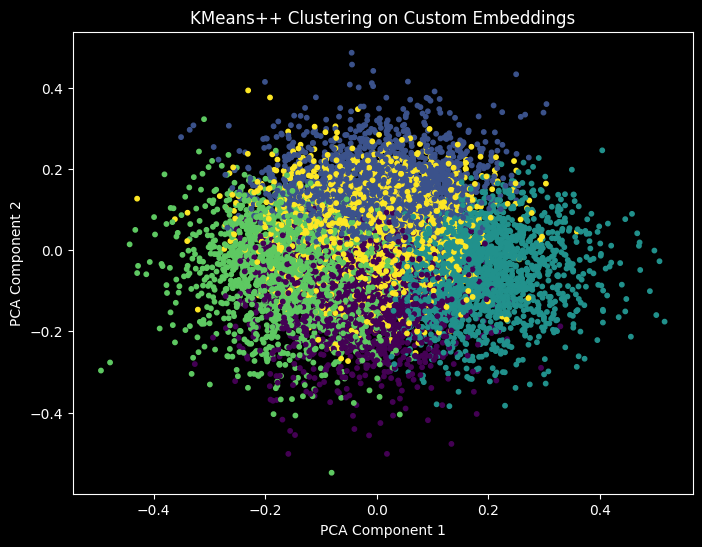

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=labels,     # color-coded by cluster
    s=10
)

plt.title("KMeans++ Clustering on Custom Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [ ]:
cluster_id = 0
df.iloc[labels == cluster_id][['Crime Type', 'Location']].head()


,Crime Type,Location
8,ಅಪಘಾತ ಪ್ರಕರಣ,ಮಲ್ಪೆ
11,ಜುಗಾರಿ ಪ್ರಕರಣ,ಗಂಗೊಳ್ಳಿ
13,ಜುಗಾರಿ ಪ್ರಕರಣ,ಬ್ರಹ್ಮಾವರ
14,ಅಪಘಾತ ಪ್ರಕರಣಗಳು,ಕೊಲ್ಲೂರು
16,ಇತರ ಪ್ರಕರಣಗಳು,ಅಮಾಸೆಬೈಲು


In [ ]:
## Build a dictionary of crime groups with the keys as the crime types and the
#values as a list of crime descriptions corresponding to that type
crime_groups = defaultdict(list)

for _, row in df.iterrows():
  #print(row['Crime Type'])
  crime_groups[row['Crime Type']].append(row['tokens'])

In [ ]:
crime_groups.keys()

dict_keys(['ಮಟ್ಕಾ ಜುಗಾರಿ ಪ್ರಕರಣ', 'ಅಸ್ವಾಭಾವಿಕ ಮರಣ ಪ್ರಕರಣ', 'ಮನುಷ್ಯ ಕಾಣೆ ಪ್ರಕರಣ', 'ಅಪಘಾತ ಪ್ರಕರಣ', 'ಜುಗಾರಿ ಪ್ರಕರಣ', 'ಅಪಘಾತ ಪ್ರಕರಣಗಳು', 'ಇತರ ಪ್ರಕರಣಗಳು', 'ಅಸ್ವಾಭಾವಿಕ ಮರಣ ಪ್ರಕರಣಗಳು', 'ಗಾಂಜಾ ಸೇವೆನೆ ಪ್ರಕರಣಗಳು', 'ಕಳವು ಪ್ರಕರಣ', 'ಇತರ ಪ್ರಕರಣ', 'ವರದಕ್ಷಣೆ ಕಿರುಕುಳ ಪ್ರಕರಣ', 'ಜುಗಾರಿ ಪ್ರಕರಣಗಳು', 'ಗಾಂಜಾ ಸೇವನೆ ಪ್ರಕರಣ', 'ಮಟ್ಕಾ ಜುಗಾರಿ ಪ್ರಕರಣಗಳು', 'ಕಳವು ಪ್ರಕರಣಗಳು', 'ಮನುಷ್ಯ ಕಾಣೆ ಪ್ರಕರಣಗಳು', 'ಹಲ್ಲೆ ಪ್ರಕರಣ', 'ಗಾಂಜಾ ಸೇವನೆ ಪ್ರಕರಣಗಳು', 'ಮಾಧಕ ವಸ್ತು ಸೇವನೆ ಪ್ರಕರಣ', 'ಗಂಡಸು ಕಾಣೆ ಪ್ರಕರಣ', 'ವಂಚನೆ ಪ್ರಕರಣಗಳು', 'ಹೆಂಗಸು ಕಾಣೆ ಪ್ರಕರಣ', 'ಗಾಂಜಾ ಪ್ರಕರಣ', 'ಕೊಲೆ ಪ್ರಕರಣ', 'ಮಾಧಕ ವಸ್ತು ಪ್ರಕರಣ', 'ಸುಲಿಗೆ ಪ್ರಕರಣ', 'ಮಾಧಕ ವಸ್ತು ಸೇವನೆ ಪ್ರಕರಣಗಳು', 'ವಂಚನೆ ಪ್ರಕರಣ', 'ಗಂಡಸು ಕಾಣೆ ಪ್ರಕರಣಗಳು', 'ಕರ್ತವ್ಯ ಅಡ್ಡಿ ಪ್ರಕರಣ', 'ವರದಕ್ಷಿಣೆ ಕಿರುಕುಳ ಪ್ರಕರಣ', 'ಹುಡುಗ ಕಾಣೆ ಪ್ರಕರಣ', 'ಹಲ್ಲೆ ಪ್ರಕರಣಗಳು', 'ಕಾಣೆ ಪ್ರಕರಣ', 'ವರದಕ್ಷಿಣೆ ಕಿರುಕುಳ ಪ್ರಕರಣಗಳು', 'ಇಸ್ಪೀಟ್ ಜುಗಾರಿ ಪ್ರಕರಣ', 'ಕೋಳಿ ಅಂಕ ಜುಗಾರಿ ಪ್ರಕರಣ', 'ಕಾಣೆ ಪ್ರಕರಣಗಳು', 'ಗಾಂಜಾ ಪ್ರಕರಣಗಳು', 'ಯುಡಿಆರ್ ಪ್ರಕರಣ', 'ಕರ್ತವ್ಯಕ್ಕೆ ಅಡ್ಡಿ ಪ್ರಕರಣ', 'ಹೆಂಗಸು ಮತ್ತು ಮಗು ಕಾಣೆ ಪ್ರಕರಣ', 'ಹಲ್ಲೆ ಪ್ರಕಣ', 'ಖೋಟಾ ನೋಟು ಪ್ರಕರಣ', 'ಹುಡುಗಿ ಕಾಣೆ ಪ್ರಕರಣ',

In [ ]:
## Custom embedding model based on the crime type

#Model
model = SimpleEmbedder(len(word2idx), dim=8)
#optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
#loss function
loss_fn = nn.CosineEmbeddingLoss()

In [ ]:
#Custom embedding training loop
num_epochs=50
epoch_loss=[]

for epoch in range (num_epochs):
    total_loss=0.0

    for crime_type, docs in crime_groups.items():
        #if a crime type has only one crime description then no contribution to training
        if len(docs)<2:
            continue

        #Pull tokens for a positive pair (samples from same crime type)
        d1_tokens, d2_tokens=random.sample(docs,2)

        #Pull tokens for a negative pair (samples from different crime type)
        neg_crime=random.choice([ct for ct in crime_groups.keys() if ct!=crime_type])
        d3_tokens=random.choice(crime_groups[neg_crime])

        #Encode the positive and negative pairs of documents
        d1= torch.tensor(encode_doc(d1_tokens))
        d2= torch.tensor(encode_doc(d2_tokens))
        d3= torch.tensor(encode_doc(d3_tokens))

        #Forward Propagation(pass)
        e1=model(d1)
        e2=model(d2)
        e3=model(d3)

        #Losses
        pos_label=torch.tensor(1.0)
        neg_label=torch.tensor(-1.0)
        loss_pos=loss_fn(e1,e2,pos_label)
        loss_neg=loss_fn(e1,e3,neg_label)
        loss=loss_pos+loss_neg

        #Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss+=loss.item()
        epoch_loss.append(total_loss)

    print(f'Epoch {epoch} loss:{total_loss:.4f}')

Epoch 0 loss:89.4894
Epoch 1 loss:88.7169
Epoch 2 loss:86.5875
Epoch 3 loss:81.9062
Epoch 4 loss:74.4385
Epoch 5 loss:82.9289
Epoch 6 loss:78.5140
Epoch 7 loss:82.0343
Epoch 8 loss:77.2488
Epoch 9 loss:78.6682
Epoch 10 loss:74.3212
Epoch 11 loss:74.9936
Epoch 12 loss:69.8065
Epoch 13 loss:67.2779
Epoch 14 loss:65.8797
Epoch 15 loss:63.3198
Epoch 16 loss:60.8086
Epoch 17 loss:65.7885
Epoch 18 loss:64.2664
Epoch 19 loss:68.7191
Epoch 20 loss:58.6906
Epoch 21 loss:62.2850
Epoch 22 loss:57.4376
Epoch 23 loss:66.2861
Epoch 24 loss:65.0753
Epoch 25 loss:62.0410
Epoch 26 loss:59.1717
Epoch 27 loss:58.1858
Epoch 28 loss:54.8320
Epoch 29 loss:54.2169
Epoch 30 loss:50.9126
Epoch 31 loss:53.9329
Epoch 32 loss:53.2699
Epoch 33 loss:59.9370
Epoch 34 loss:54.0498
Epoch 35 loss:50.4607
Epoch 36 loss:51.6304
Epoch 37 loss:50.3008
Epoch 38 loss:47.3321
Epoch 39 loss:47.9026
Epoch 40 loss:46.9339
Epoch 41 loss:51.3670
Epoch 42 loss:49.8058
Epoch 43 loss:51.1027
Epoch 44 loss:41.9959
Epoch 45 loss:47.569

In [ ]:
model.forward(torch.tensor(encode_doc(texts[1])))

tensor([ 0.1025,  0.3229, -0.3550,  0.1318,  0.0826, -0.3432, -0.0372, -0.3683],
       grad_fn=<MeanBackward1>)

In [ ]:
X_custom_embeddings = np.zeros([df.shape[0], 8])

for i in range(df.shape[0]):
  X_custom_embeddings[i] = model.forward(torch.tensor(encode_doc(texts[i]))).detach().numpy()

## Function for ranking query
def semantic_search(query, top_k = 5):
  q_vec = model.forward(torch.tensor(encode_doc(query))).detach().numpy().reshape(1,-1)
  similarities = cosine_similarity(q_vec, X_custom_embeddings)[0]
  top_doc_ids = similarities.argsort()[-top_k:][::-1]
  return top_doc_ids, similarities[top_doc_ids]

#query="ಮನೆಯೊಳಗೆ ಕಳ್ಳತನ"
query="ಮೊಬೈಲ್ ಫೋನ್ ಕಳ್ಳತನ"
semantic_search(query)

(array([ 9885,  8056,  6667, 12734,  8115]),
 array([0.72711772, 0.70325884, 0.69230531, 0.6867553 , 0.6676374 ]))

In [ ]:
df['Crime Description'].iloc[9885]

'ದಿನಾಂಕ 22/10/2016 ರಂದು ಸಂಜೆ 4:30 ಗಂಟೆಗೆ ಪಿರ್ಯಾದಿ ಬೇಬಿ ಶೆಟ್ಟಿ (34) ಗಂಡ: ರತ್ನಾಕರ ಶೆಟ್ಟಿ ನಂದ್ರೋಳ್ಳಿ ಅರಳಿಕಟ್ಟೆ ಮನೆ ಬೆಳ್ಳಾಲ ಗ್ರಾಮ, ಕುಂದಾಪುರ ಇವರು ಅನುಭವಿಸಿಕೊಂಡು ಬಂದಿರುವ ಸರಕಾರಿ ಕುಮ್ಕಿ ಜಾಗದಲ್ಲಿ ದನವನ್ನು ಮೇಯಲು ಕಟ್ಟಿದ್ದು ಆ ಸಮಯ ಅಲ್ಲಿಗೆ ಬಂದ ನರೆಮನೆ ನಿವಾಸಿಗಳಾದ ಸುಜಾತ ಮತ್ತು ಗುಲಾಬಿ ಎಂಬವರು ಬೇಬಿ ಶೆಟ್ಟಿ ರವರಲ್ಲಿ ಇದು ನಮ್ಮ ಜಾಗ ಇಲ್ಲಿಂದ ದನ ಬಿಚ್ಚಿಕೊಂಡು ಹೋಗು ಎಂದು ಅವಾಚ್ಯ ಶಬ್ಥಗಳಿಂದ ಬೈದಿರುತ್ತಾರೆ, ಬೇಬಿ ಶೆಟ್ಟಿ ರವರು ದನವನ್ನು ಬಿಚ್ಚುವುದಿಲ್ಲ ಎಂದು ಹೇಳಿದಾಗ ಆರೋಪಿಗಳು ದನಕ್ಕೆ ಕಟ್ಟಿದ್ದ ಹಗ್ಗವನ್ನು ಕಡಿಯುತ್ತೇನೆ ಎಂದು ಹೇಳಿ 1 ನೇ ಆರೋಪಿ ಸುಜಾತಳು ತಾನು ತಂದಿದ್ದ ಕತ್ತಿಯಿಂದ ದನಕ್ಕೆ ಕಟ್ಟಿದ ಹಗ್ಗವನ್ನು ಕಡಿಯಲು ಹೋದಾಗ ಬೇಬಿ ಶೆಟ್ಟಿ ರವರು ತಡೆದಿದ್ದು ಆ ಸಮಯ ಎಡ ಕೈ ಹೆಬ್ಬೆರಳು ಮತ್ತು ಹಣೆಗೆ ಕತ್ತಿ ತಾಗಿ ರಕ್ತಗಾಯವಾಗಿರುತ್ತದೆ 2 ನೇ ಆರೋಪಿ ಗುಲಾಬಿಯು ಕೋಲಿನಿಂದ ಬೇಬಿ ಶೆಟ್ಟಿ ರವರಿಗೆ ಕೈಗಳಿಗೆ ಹೊಡೆದಿರುತ್ತಾಳೆ. ಬೊಬ್ಬೆ ಕೇಳಿ ಸ್ಥಳಕ್ಕೆ ಬಂದ ನಾಗರತ್ನರವರಿಗೆ ಆರೋಪಿಗಳು “ನೀನು ಯಾಕೆ ಬಂದೆ ನಿನ್ನನ್ನು ಯಾವತ್ತೋ ಹೊಡೆಯಬೇಕೆಂದು ಇದ್ದೇವೆ ಅವಾಚ್ಯ ಶಬ್ಥಗಳಿಂದ ಬೈದ್ದು 1 ನೇ ಆರೋಪಿ ಸುಜಾತಳು ಕತ್ತಿಯನ್ನು ಬೀಸಿದ್ದರಿಂದ ಕತ್ತಿ ನಾಗರತ್ನರವರ ಎಡ ಕೈ ತೋರು ಬೆರಳಿಗೆ ತಾಗಿ ರಕ್ತಗಾಯವಾಗಿರುತ್ತದೆ ಅಲ್ಲದೇ ಆರೋಪಿಗಳು ಇನ್ನಾದರು ನಿಮ್ಮನ್ನು ಕೊಲ್ಲದೇ ಬಿಡುವುದಿ

/tmp/ipython-input-1869993619.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


Text(0.5, 1.0, 'Loss vs Epoch')

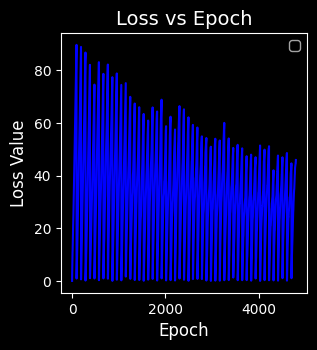

In [ ]:
#Plot loss as function of epoch
fig, ax=plt.subplots(1,1,figsize=(4,4))
fig.tight_layout(pad=4.0)
ax.plot(epoch_loss,'b')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss Value', fontsize=12)
ax.legend()
ax.set_title('Loss vs Epoch', fontsize=14)